In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


2024-11-23 18:06:19.282191: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-23 18:06:19.350448: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-23 18:06:19.425827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732365379.489170    6649 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732365379.500034    6649 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 18:06:19.539106: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
cnn_model_path = '/home/rohitb/projects/ml/Project/mri_data_analysis/trained_models/cnn_model_1.h5'
sequential_model_path = '/home/rohitb/projects/ml/Project/sequential_data_analysis/trained_models/ensamble_nb_xgb.joblib'
nb_model_path = '/home/rohitb/projects/ml/Project/sequential_data_analysis/trained_models/optimal_gaussianNB.joblib'
xgb_model_path = '/home/rohitb/projects/ml/Project/sequential_data_analysis/trained_models/optimal_XGBoost.joblib'


In [5]:
raw_data = pd.read_csv('/home/rohitb/projects/ml/Project/data/oasis_cleaned.csv')
data = raw_data[['ID','CDR']]
root_dir = '/home/rohitb/projects/ml/Project/assets/OASIS-1/processed/'
# Create lists to store images and labels
images = []
labels = []
# Walk through 8 disks
for disk_num in tqdm(range(1, 13), desc='Processing disks'):
    disk_path = os.path.join(root_dir, f'disc{disk_num}')
    for folder in tqdm(os.listdir(disk_path), desc=f'Processing folders in disk {disk_num}', leave=False):
    # for folder in list(os.listdir(disk_path))[:10]:
        folder_path = os.path.join(disk_path, folder)
        if os.path.isdir(folder_path):
            # Get CDR score for this subject
            subject_id = folder  # Append _MR1 to match ID format in data
            try:
                cdr_score = data[data['ID'] == subject_id]['CDR'].values[0]
                
                # Load all .gif images from this folder
                gif_files = [f for f in os.listdir(folder_path) if f.endswith('.gif')]
                for img_file in gif_files:
                    img_path = os.path.join(folder_path, img_file)
                    # Open and convert to grayscale numpy array
                    img = Image.open(img_path).convert('L')
                    img = img.resize((128, 128))  # Resize for consistency
                    img_array = np.array(img) / 255.0  # Normalize to [0,1]
                    images.append(img_array)
                    labels.append(cdr_score)
            except Exception as e:
                print(f"Error processing {subject_id}: {str(e)}")
                raise

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Reshape images for CNN input
X = X.reshape(-1, 128, 128, 1)
# Looking at unique CDR values to determine number of classes
unique_cdrs = np.unique(y)
num_classes = len(unique_cdrs)
print(f"Unique CDR values: {unique_cdrs}")
print(f"Number of classes: {num_classes}")


Processing disks: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Unique CDR values: [0.  0.5 1.  2. ]
Number of classes: 4


In [26]:
# Load the saved CNN model
cnn_model = tf.keras.models.load_model(cnn_model_path)

# Get predictions from CNN model
cnn_predictions = cnn_model.predict(X)￼
DOWNLOAD
￼

cnn_predictions = np.argmax(cnn_predictions, axis=1)
cnn_predictions

135/135 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [6]:
raw_data.head()
seq_data = raw_data.drop(columns=['Hand']).rename(columns={'Educ': 'EDUC'})
seq_data.head()

,ID,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,0.0,74.0,2.00,3.00,29.00,0.0,1344.0,0.743,1.306
1,OAS1_0002_MR1,0.0,55.0,4.00,1.00,29.00,0.0,1147.0,0.810,1.531
2,OAS1_0003_MR1,0.0,73.0,4.00,3.00,27.00,0.5,1454.0,0.708,1.207
3,OAS1_0004_MR1,1.0,28.0,3.39,3.25,22.09,0.5,1588.0,0.803,1.105
4,OAS1_0005_MR1,1.0,18.0,2.74,3.15,22.55,0.5,1737.0,0.848,1.010


In [28]:
# Then get probabilities for test data 
seq_model = joblib.load(sequential_model_path)
nb_model = joblib.load(nb_model_path)
xgb_model = joblib.load(xgb_model_path)
nb_test_probs = nb_model.predict_proba(seq_data.drop(columns=['ID']))
xgb_test_probs = xgb_model.predict_proba(seq_data.drop(columns=['ID']))
meta_features = np.column_stack([nb_test_probs, xgb_test_probs])
y_pred = seq_model.predict(meta_features)
y_pred

/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpick

array([2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2,
       2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 0, 2, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 0, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 0, 1, 2, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 1, 2, 1, 1,
       1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2,

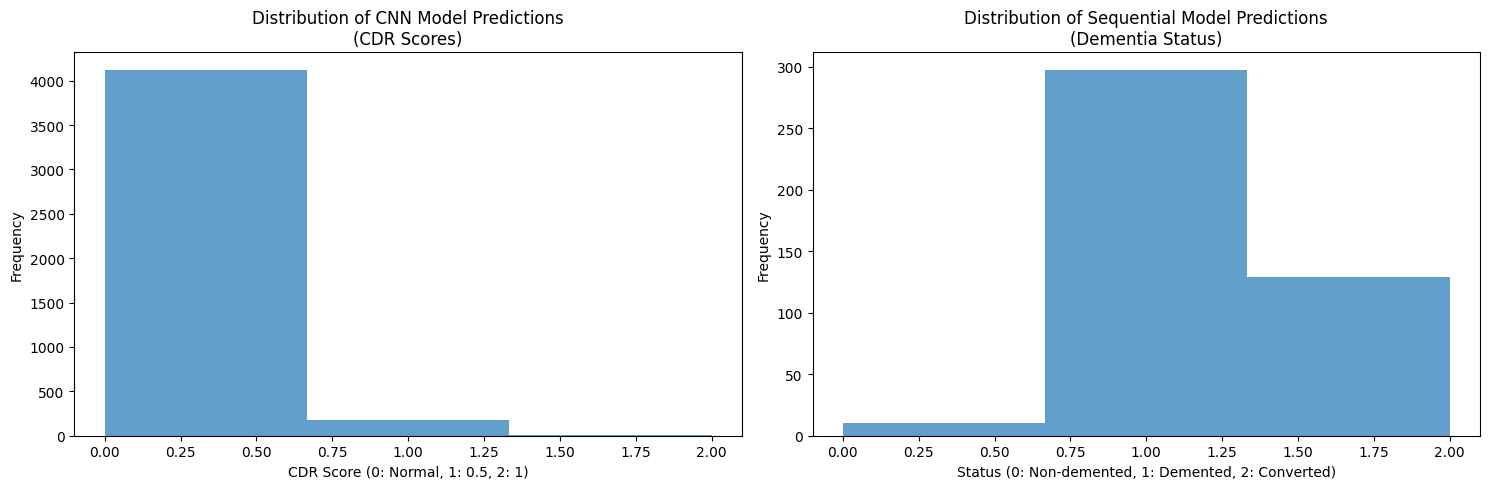

CNN Model (CDR Score) Summary:
CDR Score 0 (Normal): 4116
CDR Score 1 (0.5): 180

Sequential Model (Dementia Status) Summary:
Non-demented: 10
Demented: 297
Converted: 129


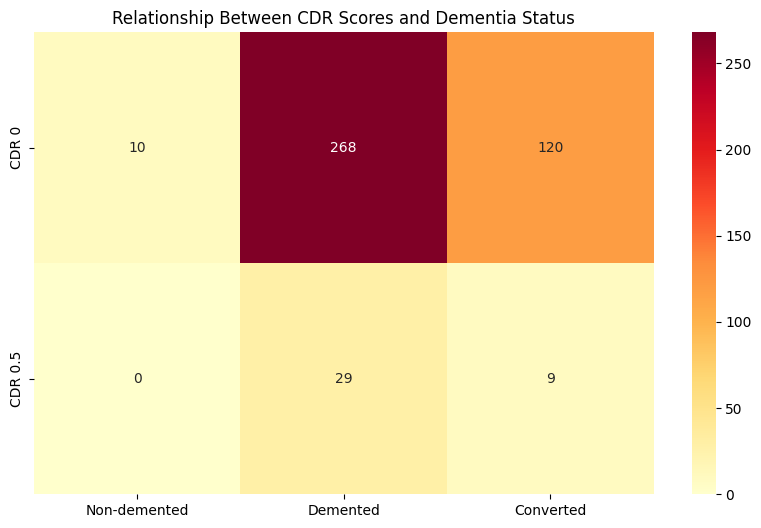


Relationship Matrix (including totals):
         Non-demented  Demented  Converted  Total
CDR 0              10       268        120    398
CDR 0.5             0        29          9     38
Total              10       297        129    436


In [30]:
# Analyze predictions from both models
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create separate distribution plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot CNN predictions (CDR scores)
ax1.hist(cnn_predictions, bins=len(np.unique(cnn_predictions)), alpha=0.7)
ax1.set_title('Distribution of CNN Model Predictions\n(CDR Scores)')
ax1.set_xlabel('CDR Score (0: Normal, 1: 0.5, 2: 1)')
ax1.set_ylabel('Frequency')

# Plot Sequential model predictions
ax2.hist(y_pred, bins=len(np.unique(y_pred)), alpha=0.7)
ax2.set_title('Distribution of Sequential Model Predictions\n(Dementia Status)')
ax2.set_xlabel('Status (0: Non-demented, 1: Demented, 2: Converted)')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print summary statistics
print("CNN Model (CDR Score) Summary:")
cdr_counts = np.bincount(cnn_predictions)
print(f"CDR Score 0 (Normal): {cdr_counts[0]}")
print(f"CDR Score 1 (0.5): {cdr_counts[1]}")
print("\nSequential Model (Dementia Status) Summary:")
status_counts = np.bincount(y_pred)
print(f"Non-demented: {status_counts[0]}")
print(f"Demented: {status_counts[1]}")
print(f"Converted: {status_counts[2]}")

# Create a relationship matrix between CDR scores and dementia status
relationship_matrix = pd.crosstab(
    pd.Series(cnn_predictions, name='CDR Score (CNN)'),
    pd.Series(y_pred, name='Dementia Status (Sequential)'),
    margins=True
)
relationship_matrix.columns = ['Non-demented', 'Demented', 'Converted', 'Total']
relationship_matrix.index = ['CDR 0', 'CDR 0.5', 'Total']

plt.figure(figsize=(10, 6))
sns.heatmap(relationship_matrix.iloc[:-1,:-1], annot=True, fmt='d', cmap='YlOrRd')
plt.title('Relationship Between CDR Scores and Dementia Status')
plt.show()

print("\nRelationship Matrix (including totals):")
print(relationship_matrix)


# Working prototype

In [35]:
test_mri_path = '/home/rohitb/projects/ml/Project/assets/OASIS-1/processed/disc5/OAS1_0152_MR1/OAS1_0152_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'
test_seq_data_path = '/home/rohitb/projects/ml/Project/data/oasis_cleaned.csv'
cnn_model_path = '/home/rohitb/projects/ml/Project/mri_data_analysis/trained_models/cnn_model_1.h5'
sequential_model_path = '/home/rohitb/projects/ml/Project/sequential_data_analysis/trained_models/ensamble_nb_xgb.joblib'
nb_model_path = '/home/rohitb/projects/ml/Project/sequential_data_analysis/trained_models/optimal_gaussianNB.joblib'
xgb_model_path = '/home/rohitb/projects/ml/Project/sequential_data_analysis/trained_models/optimal_XGBoost.joblib'


In [36]:
test_seq_data = pd.read_csv(test_seq_data_path)
test_seq_data = test_seq_data[test_seq_data['ID'] == 'OAS1_0152_MR1']
# Rename 'Educ' to 'EDUC' to match training data format
test_seq_data = test_seq_data.rename(columns={'Educ': 'EDUC'})
# Drop the 'Hand' column from test data
test_seq_data = test_seq_data.drop(columns=['Hand'])
test_seq_data.head()


,ID,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
141,OAS1_0152_MR1,0.0,23.0,3.31,3.11,22.74,0.5,1471.0,0.83,1.193


In [32]:
img_path = os.path.join(folder_path, img_file)
                        # Open and convert to grayscale numpy array
test_img = Image.open(test_mri_path).convert('L')
test_img = test_img.resize((128, 128))  # Resize for consistency
test_img_array = np.array(test_img) / 255.0  # Normalize to [0,1]
test_img_array.shape
test_img_array


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
# Load the CNN model
cnn_model = tf.keras.models.load_model(cnn_model_path)

# Reshape image array to match model input shape
test_img_array = test_img_array.reshape(-1, 128, 128, 1)

# Get CNN prediction
cnn_prediction = cnn_model.predict(test_img_array)
print("\nCNN Model Prediction:", cnn_prediction)
# Round off the CNN prediction to 2 decimal places
cnn_prediction_rounded = np.round(cnn_prediction, decimals=2)
print("\nRounded CNN Prediction:", cnn_prediction_rounded)
d = {0:0,1:0.5,2:1}
if 1 in cnn_prediction_rounded:
    print(f"\nPredicted CDR value: {d[1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step

CNN Model Prediction: [[9.99999642e-01 9.92554426e-01 1.06730545e-02 1.67564529e-09
  3.35110076e-06]]

Rounded CNN Prediction: [[1.   0.99 0.01 0.   0.  ]]

Predicted CDR value: 0.5


In [34]:
# Load the sequential models
nb_model = joblib.load(nb_model_path)
xgb_model = joblib.load(xgb_model_path) 
seq_model = joblib.load(sequential_model_path)
d = {0: 'Converted', 1: 'Demented', 2: 'Nondemented'}

nb_test_probs = nb_model.predict_proba(test_seq_data.drop(columns=['ID']))
xgb_test_probs = xgb_model.predict_proba(test_seq_data.drop(columns=['ID']))
test_meta_features = np.column_stack([nb_test_probs, xgb_test_probs])
y_pred_ensemble = seq_model.predict(test_meta_features)
print(f"\nPredicted Dementia Status: {d[y_pred_ensemble[0]]}")



Predicted Dementia Status: Demented


/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianNB from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator